The notebook outlines the telescope pointing routine to a LEO satellite from NORAD catalogue based on Two-Line Elements (TLE) data. The illustration below shows the baseline geometry of the mathematical model.

<!-- ![pointing_geometry3.png](attachment:pointing geometry 3.png) -->
<img src="pointing geometry 3.png" width="500" height="340"> 

Four reference frames are depicted. 

- Earth-centered intertial (ECI) $\textit{OXYZ}$ is used to describe satellite motion 
- Earth-centered Earth-fixed (ECEF) denoted as $O\xi\eta\zeta$ is used to specify the location of the observatory on the Earth 
- Local reference frame $\textit{oxyz}$ originates at the observatory location, x-axis points toward North, z-axis points to zenith direction, y-axis completes orthonormal reference frame to the right-handed triad. The reference frame is used to specify azimuth $\beta$ and elevation $\gamma$ of a satellite as seen from the observatory location
- Topocentric frame $OX_tY_tZ_t$ is an inertial frame aligned with the ECI frame but located at the observation site. This frame is used to define the right ascension and declination values which are used as an input to the GUI.

Note the the illustration represent a time step when both inertial ECI and noninertial ECEF reference frames coincide which is generally can be different.

Superscripts $\textit{I}$, $\textit{E}$, $\textit{L}$ defines vector representation in ECI, ECEF, and local reference frame, respectively.

In order to find celestial coordinates of a satellite during flyby - R.A. and Dec and local azimuth and elevation the following procedure is used:

1. Propagate satellite state to obtain satellite position vector $\mathbf{R}_{sat}^I(t)$ for a $t_{span}$. 
    Let us use SGP4 propagator that utilizes NORAD TLE as an input as a standard in the aerospace industry. The SGP4 outputs position $R_{sat}^I$ and velocity $V_{sat}^I$ given in ECI frame (TEME). 
2. Find obsevatory position given in ECI frame $\mathbf{R}_{obs}^I(t)$ for the time span. For the purpose its ECEF position $\mathbf{R}_{obs}^E(t)$ should be converted to ECI frame for all time steps within time span.
2. Find satellite elevation $\gamma$ 
<!-- Find vector $\mathbf{r}$ pointing from the observatory to the satellite. -->
3. For the time steps when elevation $\gamma$ exceeds the minimum required one $\gamma_{min}$ find R.A. $\alpha$, Dec $\delta$, local azimuth $\beta$ and elevation $\gamma$ and store it with the corresponding time epoch.
   
TLE data can be accessed via the link https://celestrak.org/NORAD/elements/

Another important feature is sun elevation $\gamma_{sun}$ during observations. It should be below the maximum required for the astronomical observations $\gamma_{sun} < -5^{\circ}$. The notebook considers the property. Scattered reflection is considered in the study.

<!-- Repeat the routine to obtain relative satellite trajectory arc, namely $\xi(t)$, $\gamma(t)$.

In order to find a set of satellites visible at the observatory for a given time span $\Delta t$ the following procedure is used:
1. Propagate satellite state for the time span $\Delta t$
2. Convert observatory position vector to ECI frame to for a given time span for further line-of-sight analysis
3. Calculate satellite elevation $\gamma$ during the time span
4. A set of satellites is defined by the constraint $\gamma > \gamma_{min}$, where $\gamma_{min}$ is critical satellite elevation for the observations.

TLE data can be accessed via the link https://celestrak.org/NORAD/elements/
 -->
<!-- The output satellite coordinates for the observations are given in terms of geocentric right ascencion $\xi$ and declination $\gamma$ that considers Earth equator as a reference plane.
 -->
<!-- TODO:
1. Check SGPF4 documentation and provide propagator precison position. Add data to the notebook description (Fatima, Shamil)
2. A routine to calculate satellite elevation and discard a satellite if it has no elevation above certain threshold, $\gamma_{min}$ (Shami, Fatima)
3. For a feasible satellite provide satellite position data for viable observation time when satellite is above minimum required elevation (Shamil, Fatima) -->

In [2]:
# Imports necessary libraries
from consts import *
import numpy as np
import matplotlib.pyplot as plt
import statistics
from geometry_and_transformations import *
from stateTransformation import *
from sgp4.api import Satrec
from datetime import datetime, timedelta
from astropy.time import Time
import pandas as pd
from conversions import *
from skyfield.api import load, Topos

# Defines location of the observatory 
# Data are taken from google map, Add data from Konstantin
latitude_obs = 24.177222 * np.pi / 180
longitude_obs = 54.685583 * np.pi / 180

# case of spherical Earth
# r_obs_ecef = np.vstack([Consts.rEarth * np.cos(latitude_obs) * np.cos(longitude_obs), Consts.rEarth * np.cos(latitude_obs) * np.sin(longitude_obs), Consts.rEarth * np.sin(latitude_obs)])  

# case of ellipsoidal Earth
r_Ellipsoid = calc_geocentric_radius_for_ellipsoid(latitude_obs)
r_obs_ecef = np.vstack([r_Ellipsoid * np.cos(latitude_obs) * np.cos(longitude_obs), r_Ellipsoid * np.cos(latitude_obs) * np.sin(longitude_obs), r_Ellipsoid * np.sin(latitude_obs)])  

r_obs_ecef_mag = np.linalg.norm(r_obs_ecef)

elevation_min = 40 * np.pi / 180 # radians

# print(r_obs_ecef, r_obs_ecef_mag)

Observations can be started at  DatetimeIndex(['2024-11-01 14:00:30'], dtype='datetime64[ns]', freq=None) UTC


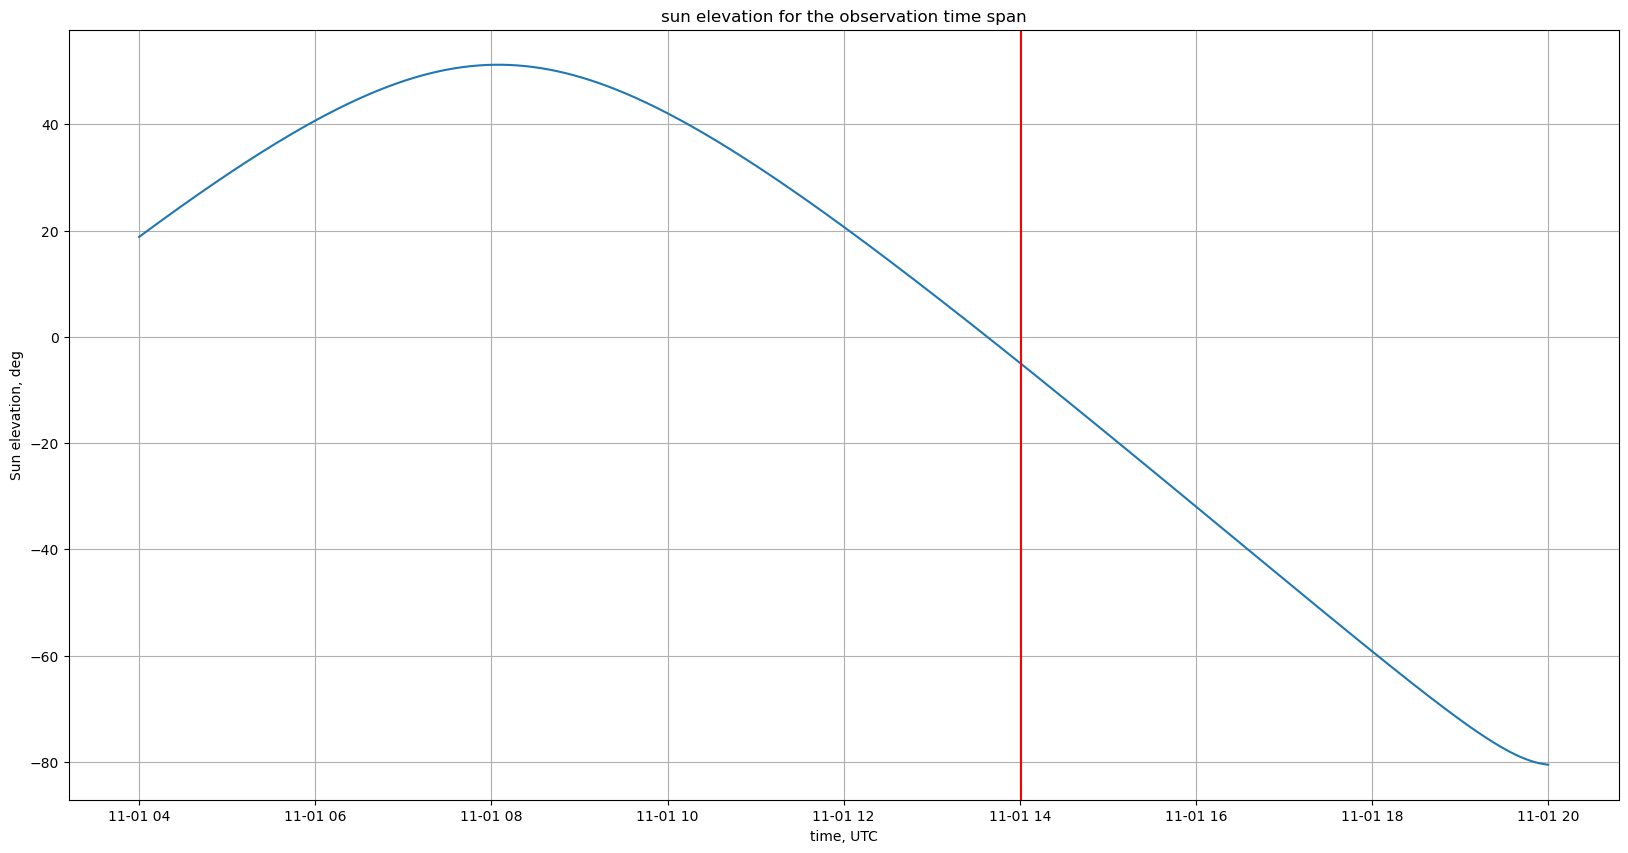

In [3]:
# Calculates sun elevation angle with respect to the observation point during observation day
# Requires to understand when the observation can be done in terms of lighting conditions

start_date_obs_day = "2024-11-01 04:00:00" # given in UTC, 8 am in Abu Dhabi
end_date_obs_day = "2024-11-01 20:00:00"   # given in UTC, midnight in Abu Dhani

# Generates a range of datetimes with certain time step
t_span_obs_day = pd.date_range(start=start_date_obs_day, end=end_date_obs_day, freq='30s')

# Converts to a list of strings if needed?
gregorian_dates_obs_day = t_span_obs_day.strftime("%Y-%m-%d %H:%M:%S").tolist()
# Converts to Julian Date
julian_dates_obs_day = Time(gregorian_dates_obs_day, format='iso').jd


# Load ephemeris data (required for accurate positions)
eph = load('de421.bsp')  # DE421 ephemeris, can be downloaded by Skyfield if not already cached
earth, sun = eph['earth'], eph['sun']
ts = load.timescale()

# Compute Sun's position relative to Earth
sunElevationArray_deg =  []
sunElevationArray_rad =  []

for jdIndx, jd in enumerate(julian_dates_obs_day):
    astrometric = earth.at(ts.tt_jd(jd)).observe(sun)
    distance, sun_vector = astrometric.distance().km, astrometric.position.km  # Get position vector in km
    
    eSun = sun_vector / np.linalg.norm(sun_vector)
    eSun = np.vstack([eSun[0], eSun[1], eSun[2]])
    r_obs_local = ecef_to_eci(r_obs_ecef, t_span_obs_day[jdIndx])
    eObs = r_obs_local / np.linalg.norm(r_obs_local)
    sunElevation = np.pi / 2 - np.arccos(np.dot(np.transpose(eObs), eSun))
    
    sunElevationArray_rad = np.concatenate((sunElevationArray_rad, np.array(sunElevation * 180 / np.pi).reshape(1)), axis=0)

    sunElevationArray_deg = np.concatenate((sunElevationArray_deg, np.array(sunElevation * 180 / np.pi).reshape(1)), axis=0)

observation_cond_logical = sunElevationArray_deg < -5
idxs_array = np.argwhere(observation_cond_logical)
observation_time_start = t_span_obs_day[idxs_array[0]]

print('Observations can be started at ', observation_time_start,  'UTC')

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(t_span_obs_day , np.transpose(sunElevationArray_deg))
plt.axvline(x = observation_time_start, color = 'r', label = 'Observation time start')
ax.set(xlabel='time, UTC', ylabel='Sun elevation, deg',
       title='sun elevation for the observation time span')
ax.grid()

fig.savefig("sun elevation.png")
plt.show()

In [4]:
# Defines observation time span

# Defines start and end date with specific time
# Datetime is given in UTC format
# Abu Dhabi time zone is UTC+4

start_date = "2024-11-01 13:00:00" # given in UTC
end_date = "2024-11-01 15:00:00"   # given in UTC

# Generates a range of datetimes with certain time step
t_span = pd.date_range(start=start_date, end=end_date, freq='10s')

# Converts to a list of strings if needed?
gregorian_dates = t_span.strftime("%Y-%m-%d %H:%M:%S").tolist()

# Converts to Julian Date
julian_dates = Time(gregorian_dates, format='iso').jd

# print(gregorian_dates)

variance r_obs_mag 2.779680252477116e-07


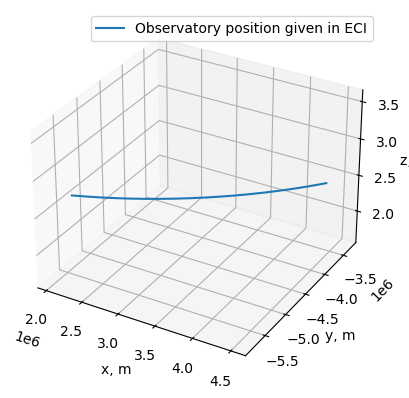

In [5]:
# Calculates station coordinates in ECI for the given time span

r_obs_eci_array = np.empty([3, 0], float)

for t in t_span:
    r_obs_eci_array = np.concatenate((r_obs_eci_array, ecef_to_eci(r_obs_ecef, t)), axis=1)


r_obs_eci_mag_array = np.linalg.norm(r_obs_eci_array, axis=0)

var_r_obs_mag = statistics.variance(r_obs_eci_mag_array) # shows position vector change, which is small enough
print('variance r_obs_mag', var_r_obs_mag)

# fig, ax = plt.subplots()
# ax.plot(t_span, r_obs_eci_mag_array)
# plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_obs_eci_array[0,:], r_obs_eci_array[1,:], r_obs_eci_array[2,:], label='Observatory position given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.axis('equal') # makes the same axes scale
ax.grid()
ax.legend()
plt.show()
# plt.savefig("Observatory position trajectory.pdf")


# fig, ax = plt.subplots()
# ax.plot(t_span, r_obs_eci_array[2,:])

# ax.set(xlabel='time, UTC', ylabel='z obs, m',
#        title='observer z coordinate change')
# ax.grid()
# plt.show()

STARLINK_31586
1 59205U 24046E   24306.45833333 -.00000192  00000-0 -64821-5 0 00007
2 59205 053.1605 286.3368 0001432 106.3829 258.1783 15.30188033037330


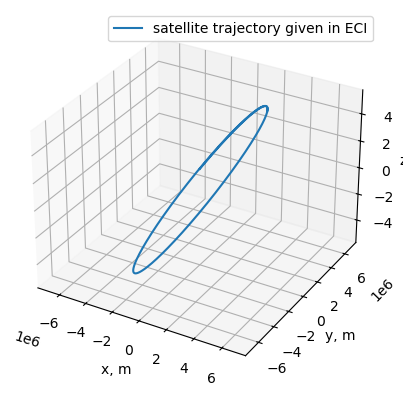

[3380901.96639818 2676056.44139992 5316950.41118505]


<Figure size 640x480 with 0 Axes>

In [7]:
# Propagates satellite state using SGP4 propagator for the given time span

# import TlE text file and choose satellite

with open('Site_Visit_1_11_2024.txt', 'r') as file:
    lines = [line.strip() for line in file]

# choose satellite indx 
satIndx = 0 # choose the one that you like
satelliteName = lines[satIndx * 3]
TleFirstLine = lines[satIndx * 3 + 1]
TleSecondLine = lines[satIndx * 3 + 2]
satellite = Satrec.twoline2rv(TleFirstLine, TleSecondLine)

print(satelliteName)
print(TleFirstLine)
print(TleSecondLine)

# Propagates satellite state for the t_span
positionsX = []
positionsY = []
positionsZ = []

r_sat_eci_array = np.empty([3, 0], float)

for jd in julian_dates:

    # Propagate
    e, r, v = satellite.sgp4(jd, 0)
    
    if e == 0:
        positionsX.append(r[0] * 1e3)
        positionsY.append(r[1] * 1e3)
        positionsZ.append(r[2] * 1e3)
    
        r_sat_eci_array = np.concatenate((r_sat_eci_array, np.vstack([r[0] * 1e3, r[1] * 1e3, r[2] * 1e3])), axis=1)

    else:
        positionsX.append(None)  # Error in propagation
        positionsY.append(None)  # Error in propagation
        positionsY.append(None)  # Error in propagation

gregorian_dates = Time(julian_dates, format='jd').to_datetime()

sat1Data = np.array([gregorian_dates, positionsX, positionsY, positionsZ]).T

sat1 = pd.DataFrame(sat1Data, columns=["Date and Time", "X, km", "Y, km", "Z, km"])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_sat_eci_array[0,:], r_sat_eci_array[1,:], r_sat_eci_array[2,:], label='satellite trajectory given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.grid()
ax.axis('equal')
ax.legend()
plt.show()
plt.savefig("satellite trajectory.png")

print(r_sat_eci_array[:, 0])
# print("Satellite 1 Position Data")
# print(sat1)

# print(np.size(r_sat_eci_array, axis=1))

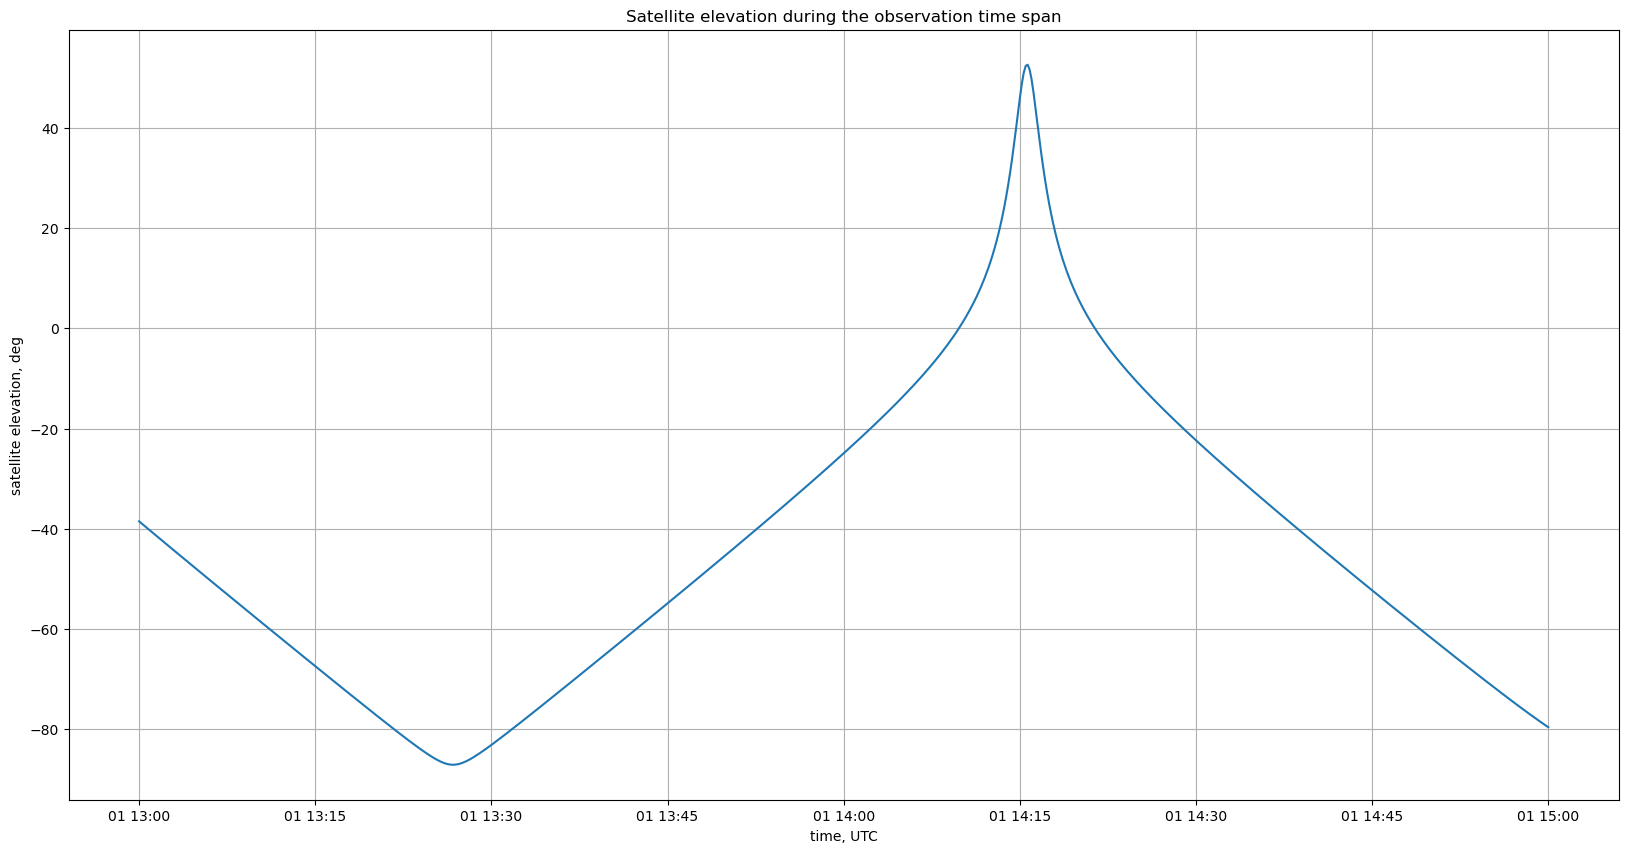

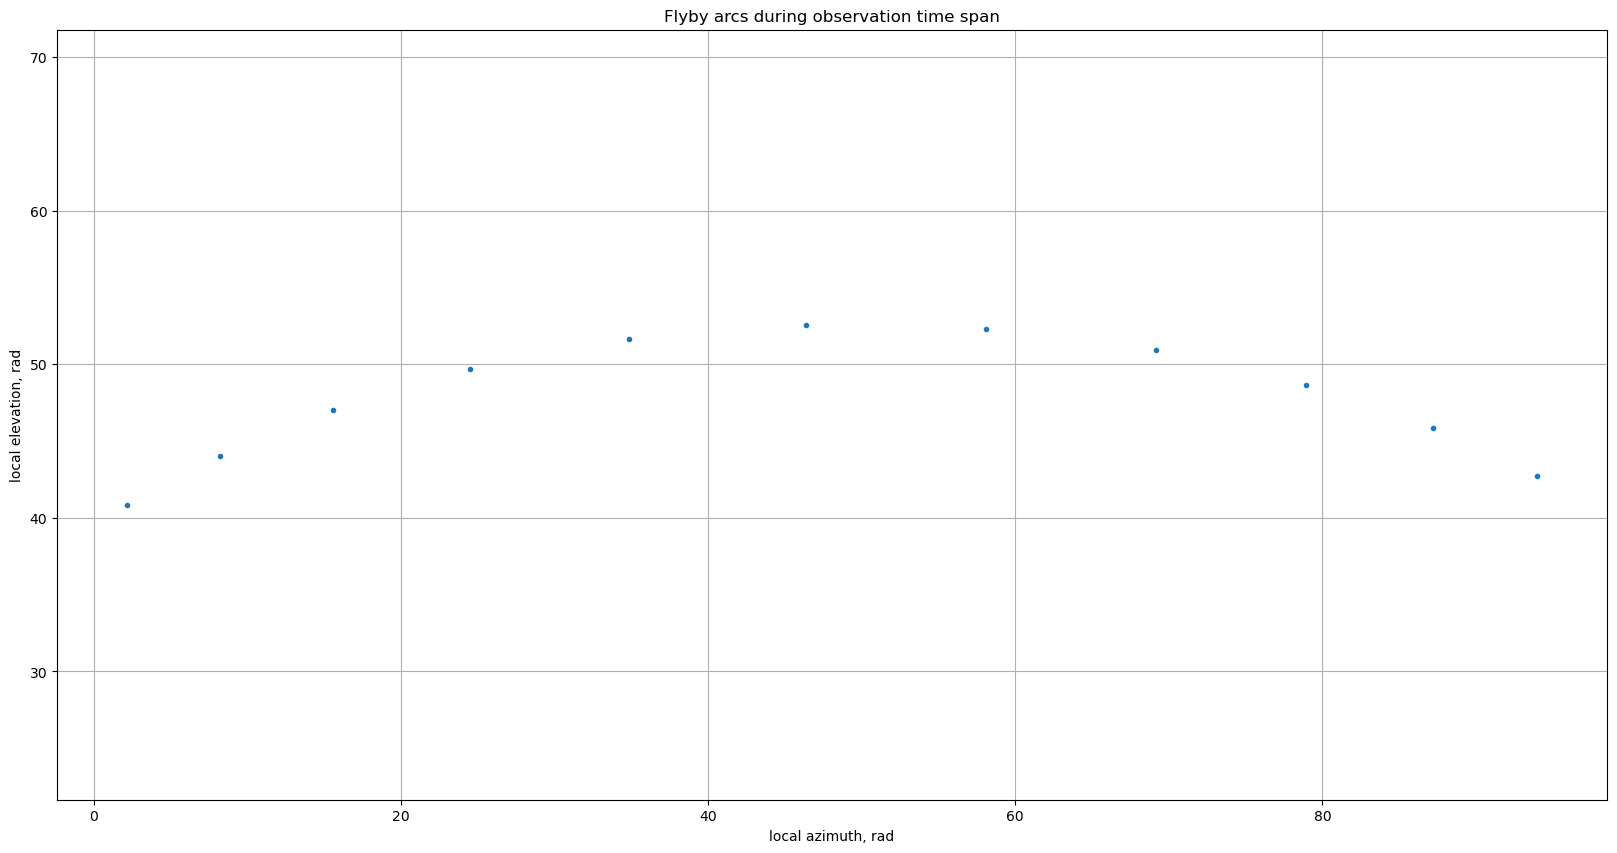

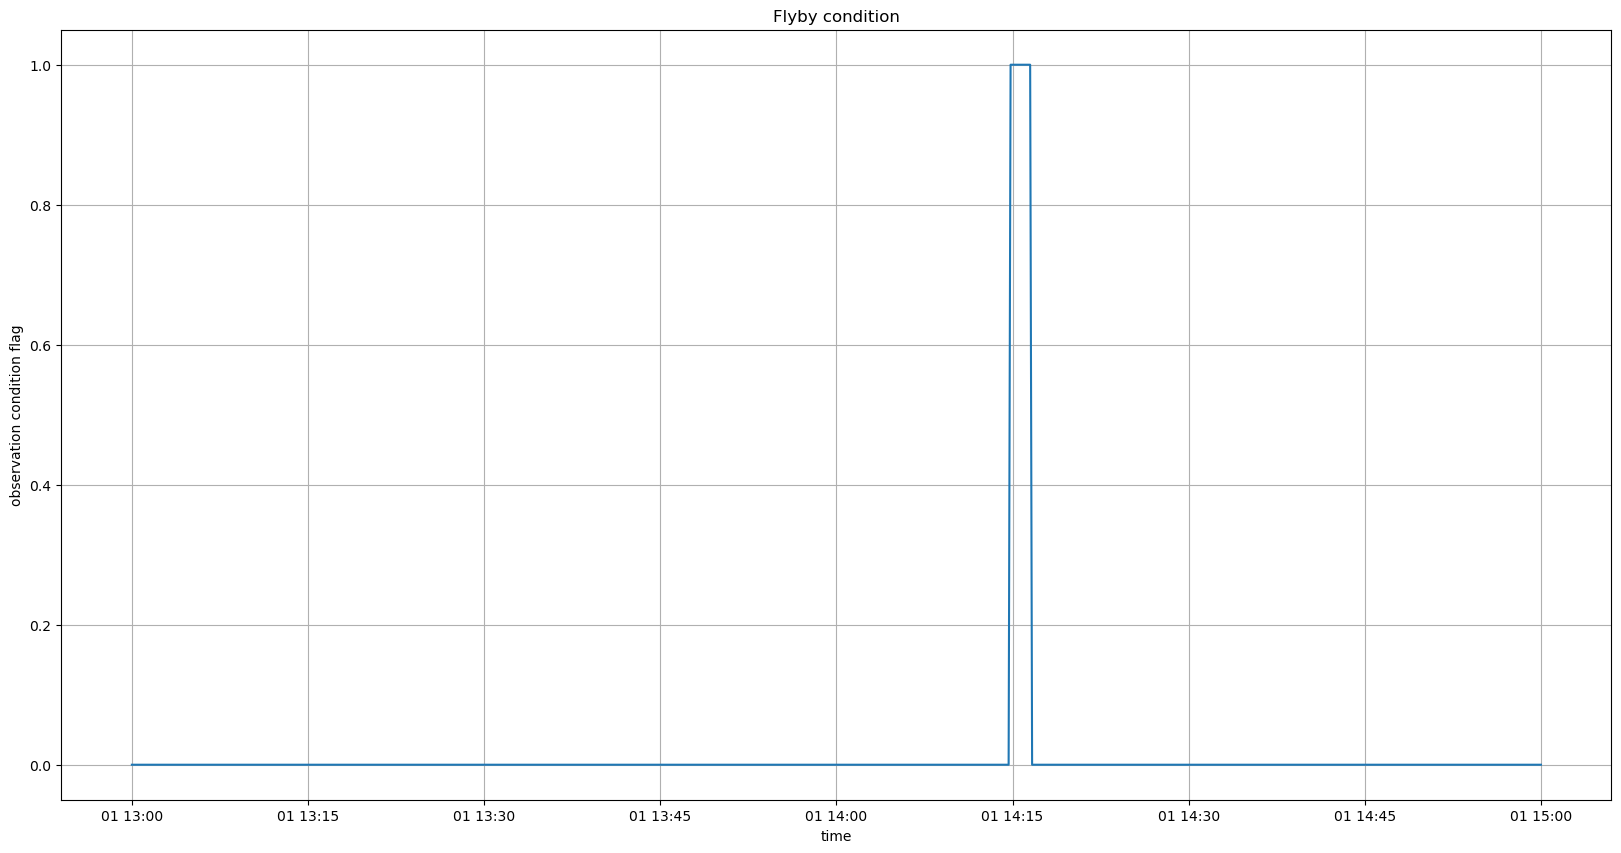

In [14]:
# Calculates satellite elevation for the given t_span
# Check if satellite goes above minimum required elevation
# If so, calculated R.A., Dec, local azimuth and elevation and stores it together with corresponding time epochs

elevation_array = []
elevation_array_deg = []

# 2D matrix, 5xNsteps with [Epoch, R.A. and Dec., location Azimuth, local elevation]  coordinates of a satellite for the time it is above certain elevation
celestial_coordinates_array = np.empty([5, 0], float) 
celestial_coordinates_array_Topo_Ra_hms_Dec_dms = np.empty([5, 0], float) 

for time_idx in range(np.size(julian_dates)):

    r_relative = r_sat_eci_array[:, time_idx] - r_obs_eci_array[:, time_idx]
    e_relative = r_relative / np.linalg.norm(r_relative)
    e_obs = r_obs_eci_array[:, time_idx] / np.linalg.norm(r_obs_eci_array[:, time_idx])

    elevation = np.pi / 2 - np.arccos(np.dot(e_obs, e_relative))

    if elevation > elevation_min:
        right_ascension, declination = calc_right_asc_and_declination_Topo(r_sat_eci_array[:, time_idx], r_obs_eci_array[:, time_idx]) # basically, it finds spherical angles
        local_azimuth, local_elevation = calc_local_azimuth_and_elevation(r_obs_eci_array[:, time_idx], r_sat_eci_array[:, time_idx])
        celestial_coordinates_array = np.concatenate((celestial_coordinates_array, np.vstack([gregorian_dates[time_idx], right_ascension, declination, local_azimuth, local_elevation])), axis=1)

        RA  = degrees_to_hms(right_ascension * 180 / np.pi)
        RAA = f"{RA[0]}:{RA[1]}:{RA[2]:.6f}"
        DEC =  degrees_to_dms(declination * 180 / np.pi)
        DECC = f"{DEC[0]}:{DEC[1]}:{DEC[2]:.6f}"

        celestial_coordinates_array_Topo_Ra_hms_Dec_dms = np.concatenate((celestial_coordinates_array_Topo_Ra_hms_Dec_dms, np.vstack([gregorian_dates[time_idx], RAA, DECC, local_azimuth, local_elevation])), axis=1)

    elevation_array.append(elevation)
    elevation_array_deg.append(elevation * 180 / np.pi)

observation_condition = elevation_array > np.repeat(elevation_min, np.size(julian_dates))

import matplotlib.pyplot as plt
import numpy as np

# sat elevation figure
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t_span, elevation_array_deg)

ax.set(xlabel='time, UTC', ylabel='satellite elevation, deg',
       title='Satellite elevation during the observation time span')
ax.grid()

# fig.savefig("satellite elevation.png")
plt.show()

# local azimuth and elevation of the satellite during flybys figure
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(celestial_coordinates_array[3,:] * 180 / np. pi, celestial_coordinates_array[4,:] * 180 / np. pi, '.')

ax.set(xlabel='local azimuth, rad', ylabel='local elevation, rad',
       title='Flyby arcs during observation time span')
ax.axis('equal')
ax.grid()

# fig.savefig("satellite flyby arcs.png")
plt.show()

# flyby conditions
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t_span, observation_condition)

ax.set(xlabel='time', ylabel='observation condition flag',
       title='Flyby condition')
ax.grid()

# fig.savefig("satellite flyby arcs.png")
plt.show()

observation_data = np.transpose(celestial_coordinates_array)
observation_data[:, 1] = observation_data[:, 1] * 180 / np.pi
observation_data[:, 2] = observation_data[:, 2] * 180 / np.pi
observation_data[:, 3] = observation_data[:, 3] * 180 / np.pi
observation_data[:, 4] = observation_data[:, 4] * 180 / np.pi

observation_data2 = np.transpose(celestial_coordinates_array_Topo_Ra_hms_Dec_dms)
observation_data2[:, 1] = observation_data2[:, 1] 
observation_data2[:, 2] = observation_data2[:, 2] 
observation_data2[:, 3] = observation_data2[:, 3] * 180 / np.pi
observation_data2[:, 4] = observation_data2[:, 4] * 180 / np.pi


obs_data = pd.DataFrame(observation_data, columns=["Date and Time, UTC", "                R.A., deg", "             Dec, deg", "           Az, deg",  "            Elev, deg"])

obs_data2 = pd.DataFrame(observation_data2, columns=["Date and Time, UTC", "        R.A., h_m_s", "     Dec, deg_m_s", "     Az, deg",  "     Elev, deg"])

filename = f'{lines[satIndx * 3]}_data.txt'  # Creates filenames like 'satellite1_data.txt', 'satellite2_data.txt', etc.
obs_data.to_csv(filename, sep='\t', index=False)


filename2 = f'{lines[satIndx * 3]}_data2.txt'  # Creates filenames like 'satellite1_data.txt', 'satellite2_data.txt', etc.
obs_data2.to_csv(filename2, sep='\t', index=False)
